<a href="https://colab.research.google.com/github/chandan2294/Time-Series-with-Deep-Learning-/blob/master/4.%20Single_Layer_Neural_Network_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try: 
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
#Import required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0-rc3


In [0]:
def plot_series(time, series, format = "-", start = 0, end = None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel('Value')
  plt.grid(True)

def trend(time, slope = 0):
  return slope * time

def seasonal_pattern(seasonal_time):
  return np.where(seasonal_time < 0.4, 
                  np.cos(seasonal_time * 2 * np.pi), 
                  1/np.exp(3 * seasonal_time))
  
def seasonality(time, period, amplitude = 1, phase = 0):
  season_time = ((time + phase) % period)/period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level = 1, seed = None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

In [0]:
time = np.arange(4 * 365 + 1, dtype = 'float32')
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

#Create the series
series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)

#Update with noise
series += noise(time, noise_level, seed = 42)


Let's start with this function *windowed_dataset* that will call a windows dataset. It will take in a data series along with the parameters for the size of the window that we want. The size of the batches to use when training, and the size of the shuffle buffer, which determines how the data will be shuffled.

* The first step will be to create a
dataset from the series using a *tf.data.Dataset* and we'll pass the series to it using its *from_tensor_slices* method

dataset = tf.data.Dataset.from_tensor_slices(series)

* We will then use the window method of the dataset based on our window_size to slice the data up into the appropriate windows. Each one being shifted by one time set. We'll keep them all the same size by setting drop_remainder = True

dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True

*   We then flatten the data out to make it easier to work with. And it will be flattened into chunks in the size of our window_size + 1

dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

* Once it's flattened, it's easy to shuffle it. You can shuffle and you pass it the shuffle buffer. Using a shuffle buffer speeds things up a bit. So for example, if you have 100,000 items in your dataset, but you set the buffer to a thousand. It will just fill the buffer with the first thousand elements, pick one of them at random. And then it will replace that with the 1,000 and first element before randomly picking again, and so on. This way with super large datasets, the random element choosing can choose from a smaller number which effectively speeds things up. The shuffled dataset is then split into the X's, which is all of the elements except the last, and the y which is the last element.

dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))

* It's then batched into the selected batch size and returned.

dataset = dataset.batch(batch_size).prefetch(1)







In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  """
  series - Training instances observed at time 
  window_size - Number of instances to be considered in a window that will be split in X and y
  batch_size - Size of the batches for instance batch_size = 5 then 5 X's and 5 y's
  shuffle_buffer - Number of instances to shuffle in a training dataset
  """
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

Now that we have a window datasets, we can start training neural networks with it. Let's start with a super simple one that's effectively a linear regression. We'll measure its accuracy, and then we'll work from there to improve that. Before we can do a training, we have to split our dataset into training and validation sets.

In [0]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

#Constants that will be passed to the windowed_dataset function
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

Here's how you can do a simple linear regression:

We create a single dense layer with its input shape being the window size. For linear regression, that's all you need. I'm using this approach. By passing the layer to a variable called L0, because later I'm want to print out its learned weights, and it's a lot easier for me to do that if I have a variable to refer to the layer for that. Then I simply define my model as a sequential containing the sole layer just like this.

In [17]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

l0 = tf.keras.layers.Dense(1, input_shape = [window_size])
model = tf.keras.models.Sequential([l0])

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


Now I'll compile and fit my model. I'll use the mean squared error as my loss function by setting loss to MSE, and my optimizer will use Stochastic Gradient Descent. I'd use this methodology instead of the raw string, so I can set parameters on it to initialize it such as the learning rate or LR and the momentum. We can experiment with different values here to see if we can get our model to converge more quickly or more accurately. 

Next you can fit your model by just passing it the dataset, which has already been preformatted with the X and y values. I'm going to run for a 100 epochs here. Ignoring the epoch by epoch output by setting verbose to zero.

In [18]:
model.compile(loss = 'mse', optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-6, momentum=0.9))
model.fit(dataset, epochs = 100, verbose = 0)

print('Layer weights {}'.format(l0.get_weights()))

Layer weights [array([[-0.04923845],
       [-0.01714974],
       [ 0.09703389],
       [-0.01992548],
       [-0.05140535],
       [-0.00151767],
       [ 0.05966645],
       [ 0.05536499],
       [-0.12114954],
       [ 0.02304291],
       [ 0.04301403],
       [-0.05439667],
       [ 0.04772409],
       [ 0.01697237],
       [-0.05389675],
       [ 0.0987827 ],
       [ 0.07065237],
       [ 0.1329707 ],
       [ 0.2199471 ],
       [ 0.49598414]], dtype=float32), array([0.0139247], dtype=float32)]


The output is displayed above which you can interpret it as first arrays having 20 values (size of window) and the secondary array has only one value. This is because the network has learned a linear regression to fit the values as best as they can. So each of the values in the first array can be seen as the weights for the 20 values in x, and the value for the second array is the b value.



# Prediction

If we want to plot our forecasts for every point on the time-series relative to the 20 points before it where our window size was 20, we can write code like in following cell. We create an empty list of forecasts and then iterate over the series taking slices and window size, predicting them, and adding the results to the forecast list. 


We had split our time series into training and testing sets taking everything before a certain time is training and the rest is validation. So we'll just take the forecasts after the split time and load them into a NumPy array for charting.

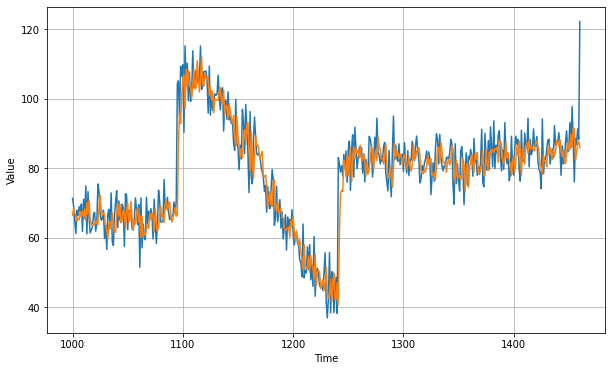

In [19]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [20]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.083077